In [ ]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kanishk3813/pathogen-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.43G/1.43G [00:23<00:00, 66.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kanishk3813/pathogen-dataset/versions/1


In [ ]:
train_data='/root/.cache/kagglehub/datasets/kanishk3813/pathogen-dataset/versions/1/pathogen'

In [ ]:
import pathlib as path
train_img=path.Path(train_data)
train_img

PosixPath('/root/.cache/kagglehub/datasets/kanishk3813/pathogen-dataset/versions/1/pathogen')

In [ ]:
import os
import shutil
import random

# Set the paths
source_folder = train_data  # Your main folder with 5 class folders
train_folder = '/content/train_data'    # Output folder for train split
test_folder = '/content/test_data'      # Output folder for test split
split_ratio = 0.8                        # Percentage of data to go into the train set

# Create train and test folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Iterate over each class folder in the source directory
for class_folder in os.listdir(source_folder):
    class_path = os.path.join(source_folder, class_folder)
    if os.path.isdir(class_path):
        # List all files in the class folder and shuffle them
        files = os.listdir(class_path)
        random.shuffle(files)

        # Calculate split index
        split_index = int(len(files) * split_ratio)

        # Separate files for train and test
        train_files = files[:split_index]
        test_files = files[split_index:]

        # Create class folders in train and test folders
        train_class_path = os.path.join(train_folder, class_folder)
        test_class_path = os.path.join(test_folder, class_folder)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        # Move the files to the respective folders
        for file in train_files:
            shutil.copy(os.path.join(class_path, file), train_class_path)

        for file in test_files:
            shutil.copy(os.path.join(class_path, file), test_class_path)

print("Data split completed successfully.")


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_img,
    image_size=(224, 224),  # Resize images to 256x256
    batch_size=64,          # Batch size
    label_mode='int',       # 'int' for integer labels, 'categorical' for one-hot encoding
    seed=123,               # Random seed for shuffling the data
    validation_split=0.2,   # Split 20% for validation
    subset="training"       # Use this subset for training
)

Found 39997 files belonging to 5 classes.
Using 31998 files for training.


In [ ]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_img,
    image_size=(224, 224),
    batch_size=64,
    label_mode='int',
    seed=123,

    validation_split=0.2,
    subset="validation"
)

Found 39997 files belonging to 5 classes.
Using 7999 files for validation.


In [ ]:
# test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     test_folder,
#     image_size=(224, 224),
#     batch_size=32,
#     label_mode='int',
#     seed=123
# )

Found 8000 files belonging to 5 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load MobileNetV2 from keras.applications, not keras.preprocessing
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),  # Image size expected by MobileNetV2
    include_top=False,          # Exclude the top classification layer
    weights='imagenet'          # Load pre-trained ImageNet weights
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import tensorflow
def process(image,label):
    image = tensorflow.cast(image/224 ,tensorflow.float32)
    return image,label

train_ds = dataset.map(process)
val_dataset = validation_dataset.map(process)

In [ ]:
base_model.trainable = False

In [ ]:
data_augmentation = models.Sequential([
    # layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.1),
    layers.RandomRotation(0.1),
], name="data_augmentation")

In [ ]:
# Add a custom classification head
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),  # Define input shape explicitly
    # data_augmentation,                  # Apply data augmentation
    base_model,
    layers.Dropout(0.3),        # MobileNetV2 base model
    layers.GlobalAveragePooling2D(),    # Pooling layer
    layers.Dense(5, activation='softmax')  # Output layer for 5 classes
])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           6,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history=model.fit(dataset, validation_data=validation_dataset, epochs=5)

Epoch 1/5
 33/500 ━━━━━━━━━━━━━━━━━━━━ 24:08 3s/step - accuracy: 0.3002 - loss: 1.5917

KeyboardInterrupt: 

In [ ]:

# model.save('pathogen_classifier2.h5')

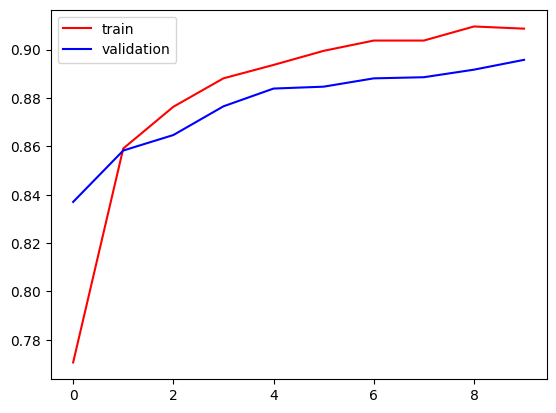

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()

plt.show()

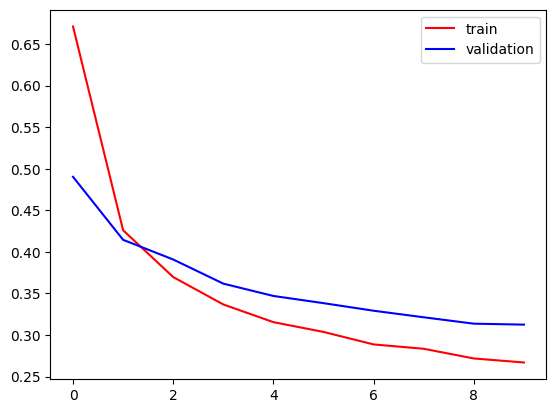

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the validation dataset
test_dataset= "/content/test_data"
test_loss, test_accuracy = model.evaluate(test_folder)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


ValueError: Unrecognized data type: x=/content/test_data (of type <class 'str'>)

In [ ]:
print(len(true_labels), len(predicted_classes))
predicted_classes = predicted_classes[:len(true_labels)]



6399 8000


In [ ]:
# Get predictions
predictions = model.predict(test_dataset)

# For classification tasks, use argmax to get the predicted class
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels (this may depend on your dataset's structure)
true_labels = np.concatenate([y for x, y in validation_dataset], axis=0)
predicted_classes = predicted_classes[:len(true_labels)]

# Compare predictions with true labels
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_classes))



250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step
              precision    recall  f1-score   support

           0       0.18      0.17      0.18      1259
           1       0.21      0.20      0.21      1259
           2       0.19      0.19      0.19      1322
           3       0.20      0.20      0.20      1295
           4       0.19      0.22      0.21      1264

    accuracy                           0.20      6399
   macro avg       0.20      0.20      0.20      6399
weighted avg       0.20      0.20      0.20      6399



In [ ]:
model.save('pathogen_classifier.h5')


In [ ]:
from tensorflow.keras.models import load_model
model= load_model('pathogen_classifier.h5')

In [ ]:
import numpy

from tensorflow.keras.preprocessing import image

img_path="images.jpeg"
img = image.load_img(img_path, target_size=(224, 224))  # MobileNet uses 224x224 image size

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to match the input format of the model (batch size, height, width, channels)
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (MobileNet expects pixel values between 0 and 1)
img_array /= 255.0

In [ ]:
# Predict the class probabilities
predictions = model.predict(img_array)

# Get the class with the highest probability
predicted_class = np.argmax(predictions, axis=1)

print(f"Predicted class index: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class index: [0]


In [ ]:
class_names = ['bacteria', 'fungi', 'healthy', 'pectobacterium', 'other']
predicted_class_name = class_names[predicted_class]


print(f"Predicted class name: {predicted_class_name}")

TypeError: only integer scalar arrays can be converted to a scalar index